In [1]:
import os
import re
from datetime import datetime

from dateutil import parser
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import statsmodels.stats.multitest as stats
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

In [2]:
matplotlib.rc('xtick', labelsize=10) 

In [3]:
# sns.set(font='Times New Roman')

In [4]:
output_dir = '/Users/estorrs/Documents/emily-analysis/outputs'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [5]:
df = pd.read_csv('/Users/estorrs/Downloads/storm_results_190610_correction.csv', sep=',', encoding='latin')

print(df.shape)
df.head()

(196, 37)


,site,Impervious surface (%),Number of karst features,Number of sinkholes,Forest cover (%),Developed open space (%),Watershed area (km2),nest,time_start,time_lamber_-5hr,...,Def_type,notes,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,NaN,10/7/2018 13:15,10/6/2018 18:51,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,NaN,6/25/2018 17:55,6/26/2018 6:51,...,1.0,kept 6/19 BF value; compound storm with antece...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,NaN,8/29/2018 5:40,8/29/2018 6:51,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,NaN,5/20/2018 4:55,5/21/2018 0:51,...,1.0,tail of 95% BF stop dragged out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,NaN,8/10/2018 12:05,8/10/2018 18:51,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.columns

Index(['site', 'Impervious surface (%)', 'Number of karst features',
       'Number of sinkholes', 'Forest cover (%)', 'Developed open space (%)',
       'Watershed area (km2)', 'nest', 'time_start', 'time_lamber_-5hr',
       'Lambert_ppt_mm', 'Lag time (minutes)', 'time_end_est1',
       'time_end_5%peak', 'time_end_95_BF_2hr', 'time_peak',
       'Peak Discharge (m3/s)', '5%_peak', 'Peak discharge (m3/s)',
       'Baseflow at peakflow', 'Area normmalized baseflow at peakflow',
       'time_Bfmin', 'Baseflow minimum', 'Baseflow with 5peak method',
       'Baseflow with 95_2hr method', 'adjusted 95_2hr with 5peak',
       'Total baseflow (%)', 'Def_type', 'notes', 'Unnamed: 29', 'Unnamed: 30',
       'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34',
       'Unnamed: 35', 'Unnamed: 36'],
      dtype='object')

In [7]:
to_keep = ['site', 'Impervious surface (%)', 'Number of karst features', 'Number of sinkholes', 'Forest cover (%)',
           'Developed open space (%)', 'Watershed area (km2)', 'time_start', 'Lag time (minutes)',
           'Peak Discharge (m3/s)', 'Peak discharge (m3/s)', 'Baseflow at peakflow',
           'Area normmalized baseflow at peakflow', 'Baseflow minimum', 'Baseflow with 5peak method',
           'Baseflow with 95_2hr method', 'Total baseflow (%)'
          ]

df = df[to_keep]
df.head()

,site,Impervious surface (%),Number of karst features,Number of sinkholes,Forest cover (%),Developed open space (%),Watershed area (km2),time_start,Lag time (minutes),Peak Discharge (m3/s),Peak discharge (m3/s),Baseflow at peakflow,Area normmalized baseflow at peakflow,Baseflow minimum,Baseflow with 5peak method,Baseflow with 95_2hr method,Total baseflow (%)
0,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,10/7/2018 13:15,1399.0,37.3,1.056218,0.250752,9.050000e-09,0.249851,0.633895,NaN,0.633895
1,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,6/25/2018 17:55,999.0,40.4,1.144001,0.743809,2.910000e-08,0.528397,0.676582,NaN,0.676582
2,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,8/29/2018 5:40,299.0,69.7,1.973684,0.654410,4.410000e-08,0.273620,0.628588,0.663801,0.628588
3,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,5/20/2018 4:55,99.0,74.6,2.112437,0.518144,3.740000e-08,0.486107,0.639337,0.687306,0.639337
4,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,8/10/2018 12:05,NaN,88.8,2.514536,0.626000,5.380000e-08,0.624000,0.706497,0.716926,0.706497


In [8]:
def bin_date_storm(n):
    if n in [12.0, 1.0, 2.0]:
        return 'winter'
    elif n in [3.0, 4.0, 5.0]:
        return 'spring'
    elif n in [6.0, 7.0, 8.0]:
        return 'summer'
    elif n in [9.0, 10.0, 11.0]:
        return 'fall'
    
    return np.nan

def bin_ISA(n):
    if n > 30:
        return 'urban'
    elif n > 20:
        return 'suburban'
    elif n > 0:
        return 'rural'
    
    return np.nan

def datetime_string_to_month(datetime_str):
    
#     print(datetime_str)
    d = parser.parse(datetime_str)
    
    return d.month

df['date_storm'] = [d if pd.isna(d) else datetime_string_to_month(d) for d in df['time_start']]
df['Season'] = [bin_date_storm(n) for n in df['date_storm']]

df['Land use'] = [n if pd.isna(n) else bin_ISA(n)
                            for n in df['Impervious surface (%)']]

In [9]:
#Convert Baseflow minimum, Baseflow at Peakflow and Total baseflow (%) from fraction to a percent.
for c in ['Baseflow minimum', 'Baseflow at peakflow', 'Total baseflow (%)']:
    df[c] = [x * 100 for x in df[c]]

df.head()

,site,Impervious surface (%),Number of karst features,Number of sinkholes,Forest cover (%),Developed open space (%),Watershed area (km2),time_start,Lag time (minutes),Peak Discharge (m3/s),Peak discharge (m3/s),Baseflow at peakflow,Area normmalized baseflow at peakflow,Baseflow minimum,Baseflow with 5peak method,Baseflow with 95_2hr method,Total baseflow (%),date_storm,Season,Land use
0,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,10/7/2018 13:15,1399.0,37.3,1.056218,25.075182,9.050000e-09,24.985144,0.633895,NaN,63.389472,10.0,fall,rural
1,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,6/25/2018 17:55,999.0,40.4,1.144001,74.380883,2.910000e-08,52.839741,0.676582,NaN,67.658231,6.0,summer,rural
2,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,8/29/2018 5:40,299.0,69.7,1.973684,65.441010,4.410000e-08,27.361970,0.628588,0.663801,62.858754,8.0,summer,rural
3,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,5/20/2018 4:55,99.0,74.6,2.112437,51.814427,3.740000e-08,48.610714,0.639337,0.687306,63.933745,5.0,spring,rural
4,BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,8/10/2018 12:05,NaN,88.8,2.514536,62.600000,5.380000e-08,62.400000,0.706497,0.716926,70.649686,8.0,summer,rural


In [10]:
ts = list(set([t for t in zip(df['site'], df['Impervious surface (%)']) if not pd.isna(t[0])]))
# site_order = [s for s, _ in sorted(ts, key=lambda x:x[1])]
hue_order = [s for _, s in sorted(ts, key=lambda x:x[1])]
hue_order

[1.62, 7.1, 13.57, 19.57, 25.55, 27.35, 28.04, 28.81, 31.95, 32.52, 35.34]

In [11]:
# want for baseflow minimum, baseflow at peakflow, area normalized baseflow at peakflow, total baseflow and lag time

# Also want these plots with forest cover, number of karst features, and open space as explanatory variables. ISA

dependent = ['Baseflow minimum', 'Baseflow at peakflow', 'Area normmalized baseflow at peakflow',
              'Total baseflow (%)', 'Lag time (minutes)']
explanitory = ['Impervious surface (%)', 'Forest cover (%)', 'Number of karst features', 'Developed open space (%)']

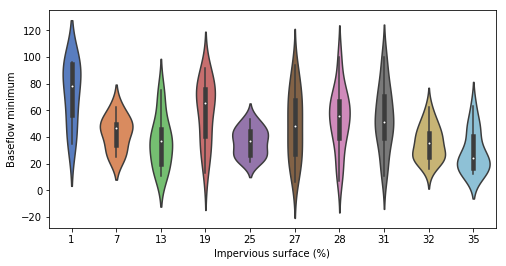

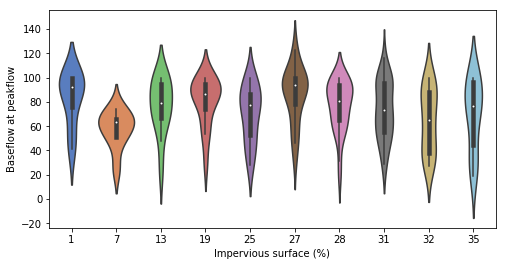

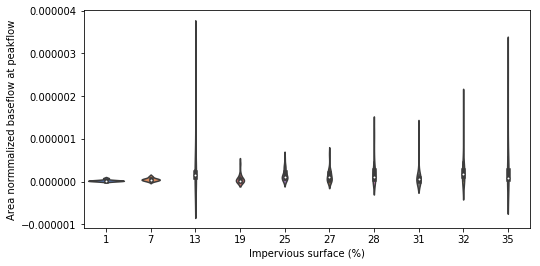

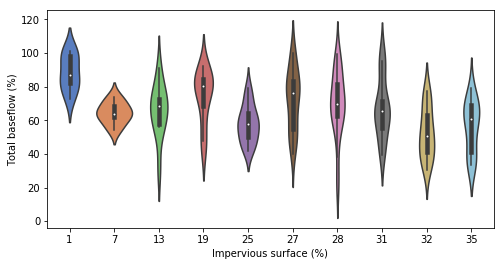

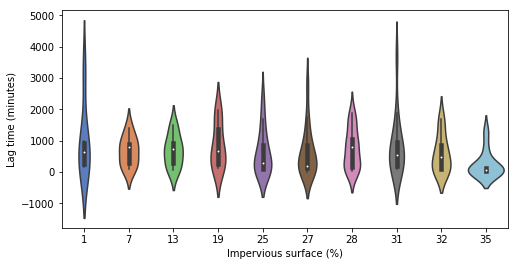

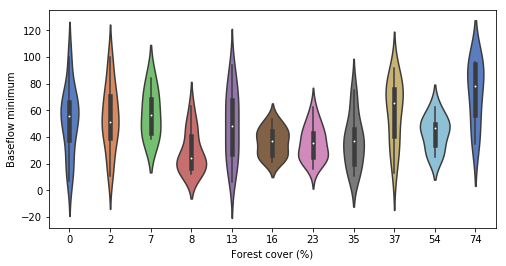

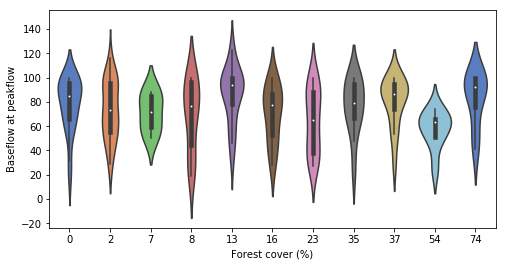

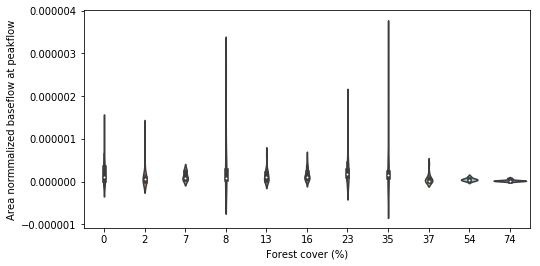

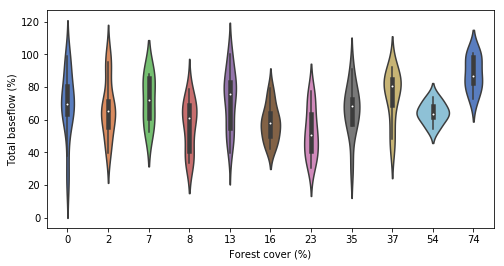

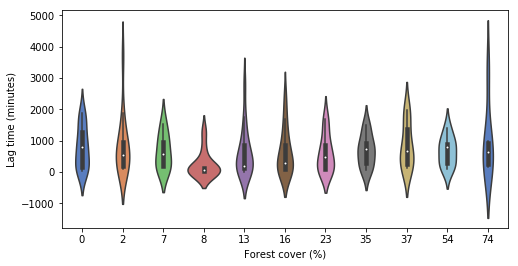

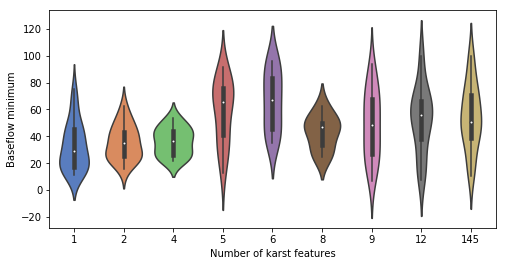

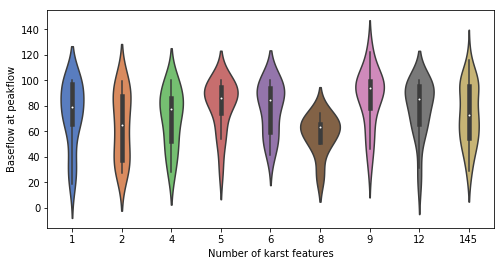

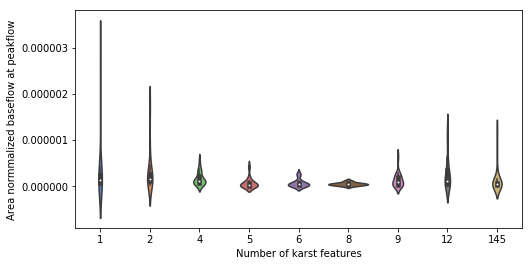

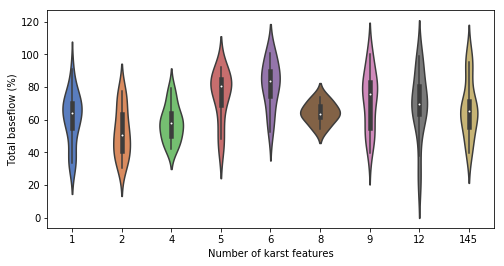

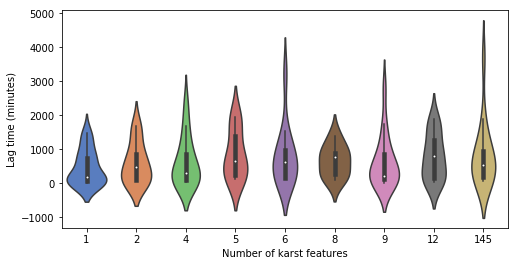

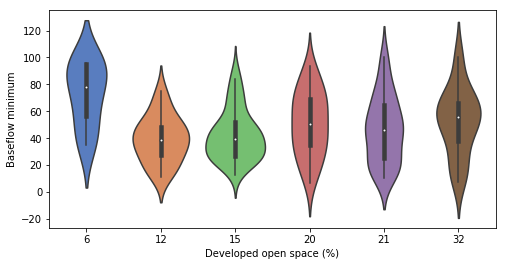

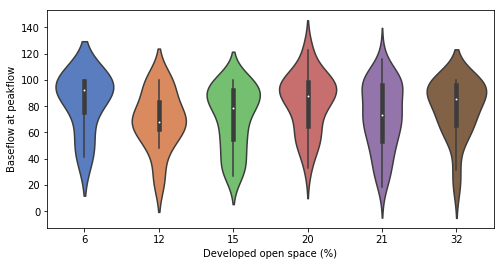

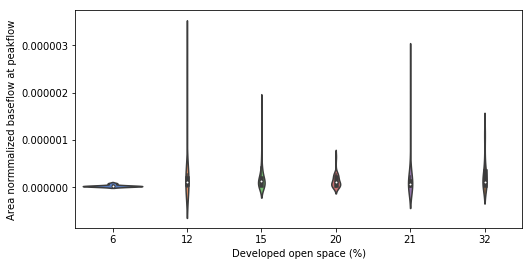

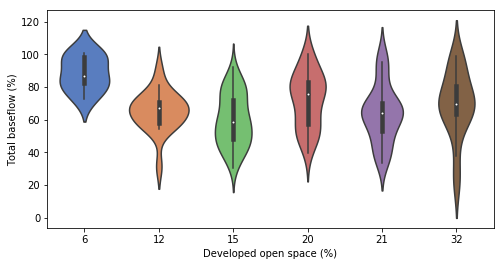

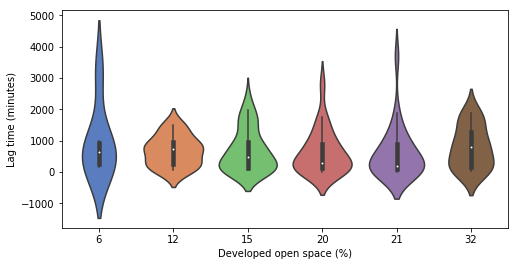

In [12]:
def create_figure(df, x, y):
    mini_df = df[[x, y]].dropna()
    corr, p_value = scipy.stats.pearsonr(mini_df[x], mini_df[y])
    mini_df[x] = [int(val) for val in mini_df[x]]
    order = sorted({val for val in mini_df[x]})
    
    fig, ax = plt.subplots(figsize=(8,4))
    
    axs = sns.violinplot(ax=ax, x=x, y=y, data=mini_df, order=order, palette='muted')
    
    plt.savefig(f'scatterplot_{x}_{y}.pdf')
    
    return corr, p_value
    
es, ds, corrs, p_values = [], [], [], []
# create_figure(df, 'Impervious surface (%)', 'Baseflow minimum')
for e in explanitory:
    for d in dependent:  
        corr, p_value = create_figure(df, e, d)
        es.append(e)
        ds.append(d)
        corrs.append(corr)
        p_values.append(p_value)

In [13]:
stats_df = pd.DataFrame.from_dict({'explanitory': es, 'dependent': ds, 'correlation': corrs, 'p_value': p_values})
stats_df

,explanitory,dependent,correlation,p_value
0,Impervious surface (%),Baseflow minimum,-0.158621,0.033940
1,Impervious surface (%),Baseflow at peakflow,-0.041161,0.585394
2,Impervious surface (%),Area normmalized baseflow at peakflow,0.110074,0.151800
3,Impervious surface (%),Total baseflow (%),-0.259718,0.000626
4,Impervious surface (%),Lag time (minutes),-0.105328,0.250232
5,Forest cover (%),Baseflow minimum,0.081304,0.279275
6,Forest cover (%),Baseflow at peakflow,-0.015529,0.837000
7,Forest cover (%),Area normmalized baseflow at peakflow,-0.107257,0.162620
8,Forest cover (%),Total baseflow (%),0.152652,0.046887
9,Forest cover (%),Lag time (minutes),0.061555,0.502402


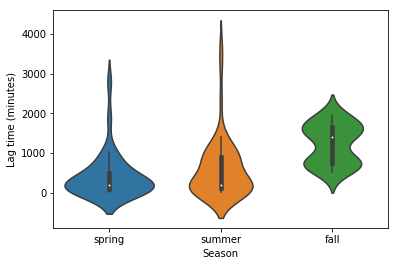

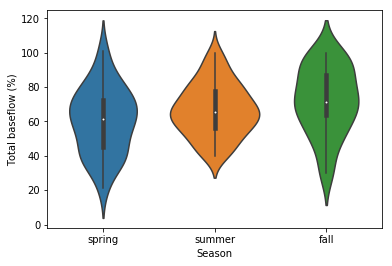

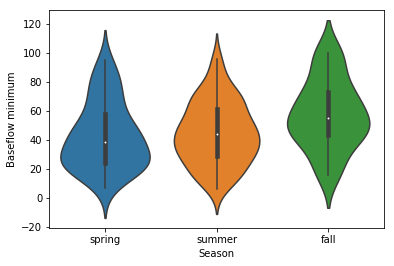

<Figure size 432x288 with 0 Axes>

In [14]:
y_vars = ['Lag time (minutes)', 'Total baseflow (%)', 'Baseflow minimum']

for y_variable in y_vars:
    ax = sns.violinplot(x="Season", y=y_variable, data=df,
                       order=['spring', 'summer', 'fall'])
    plt.show()
    plt.savefig(f'Season_vs_{y_variable}.pdf')

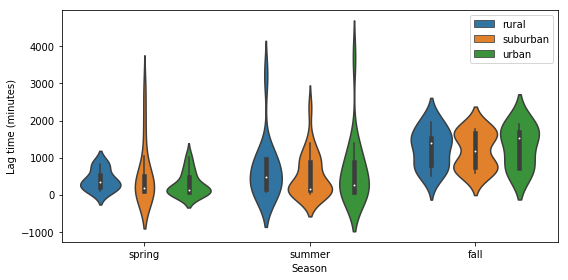

<Figure size 432x288 with 0 Axes>

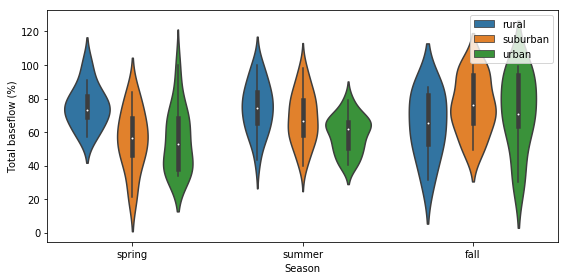

<Figure size 432x288 with 0 Axes>

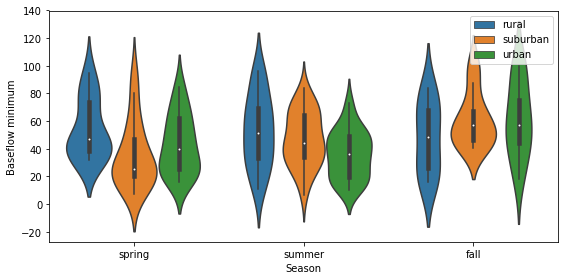

<Figure size 432x288 with 0 Axes>

In [19]:
for y_variable in y_vars:
    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.violinplot(ax=ax, x="Season", y=y_variable, data=df, hue='Land use',
                       order=['spring', 'summer', 'fall'])
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'Season_vs_{y_variable}.pdf')